In [1]:
from google.colab import files

# Upload the first file (e.g., Wednesday)
uploaded = files.upload()
# Use the exact filename from upload (copy/paste name if needed)
import shutil
shutil.move("Wednesday-workingHours.pcap_ISCX.csv", "wednesday.csv")

# Upload the second file (e.g., Tuesday)
uploaded = files.upload()
shutil.move("Tuesday-WorkingHours.pcap_ISCX.csv", "tuesday.csv")

# Upload the third file (e.g., Thursday)
uploaded = files.upload()
shutil.move("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", "thursday.csv")


Saving Wednesday-workingHours.pcap_ISCX.csv to Wednesday-workingHours.pcap_ISCX.csv


Saving Tuesday-WorkingHours.pcap_ISCX.csv to Tuesday-WorkingHours.pcap_ISCX.csv


Saving Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv to Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv


'thursday.csv'

In [2]:
# Reload the full CSV without filtering first
import pandas as pd
import numpy as np
import shutil
df1 = pd.read_csv("wednesday.csv")
df2 = pd.read_csv("tuesday.csv")
df3 = pd.read_csv("thursday.csv")


for df in [df1, df2, df3]:
    df.columns = df.columns.str.strip()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

# Label source for tracking
df1["Source"] = "Wednesday"
df2["Source"] = "Tuesday"
df3["Source"] = "Thursday"

# Combine datasets
df = pd.concat([df1, df2, df3], ignore_index=True)

In [4]:
df = df[df['Label'].isin([
    'BENIGN',
    'DoS Hulk',
    'DoS GoldenEye',
    'DoS slowloris',
    'DoS Slowhttptest'
])]

In [5]:
#preprocess
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

df = df.replace([np.inf, -np.inf], np.nan).dropna()
X = df.drop(['Label', 'Source'], axis=1)  # Drop 'Source' to avoid string error
y = df['Label']

# Encode multiclass labels: e.g., BENIGN=0, Hulk=1, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

# Train RF
rf = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
start_rf = time.time()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
end_rf = time.time()
print(f"Random Forest runtime: {end_rf - start_rf:.2f} seconds")
evaluate_model("Random Forest", y_test, rf_preds)


Random Forest runtime: 685.09 seconds

Random Forest Results:
Confusion Matrix:
 [[231888      0     83      0      0]
 [    10   2041      7      1      0]
 [    33      1  45991      0      0]
 [     6      1      0   1093      0]
 [     8      1      0      2   1148]]
Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    231971
   DoS GoldenEye       1.00      0.99      0.99      2059
        DoS Hulk       1.00      1.00      1.00     46025
DoS Slowhttptest       1.00      0.99      1.00      1100
   DoS slowloris       1.00      0.99      1.00      1159

        accuracy                           1.00    282314
       macro avg       1.00      0.99      1.00    282314
    weighted avg       1.00      1.00      1.00    282314



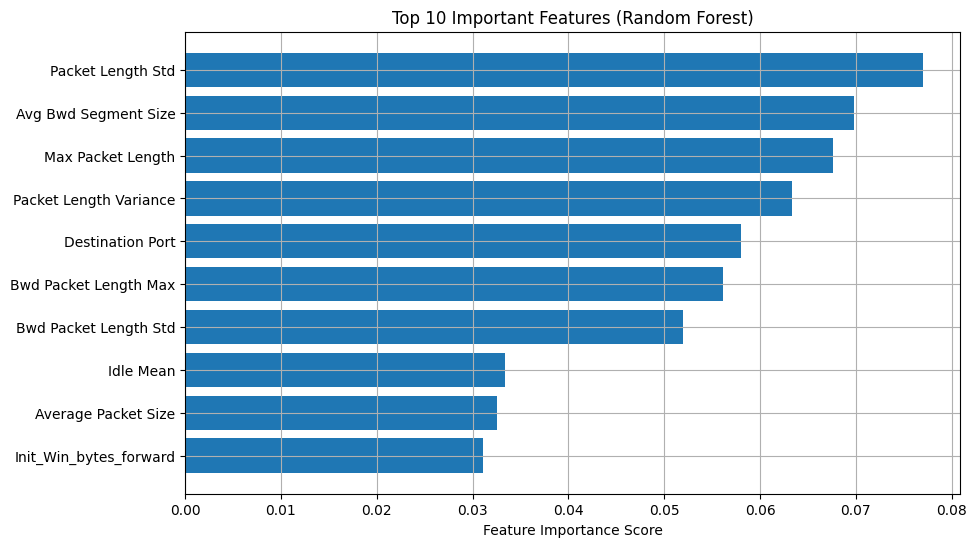

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Reshape for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN model
cnn = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
start_cnn = time.time()
cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1)
end_cnn = time.time()
print(f"CNN training time: {end_cnn - start_cnn:.2f} seconds")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - accuracy: 0.9730 - loss: 0.0681 - val_accuracy: 0.9889 - val_loss: 0.0304
Epoch 2/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 213s 10ms/step - accuracy: 0.9851 - loss: 0.0315 - val_accuracy: 0.9920 - val_loss: 0.0256
Epoch 3/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 150s 9ms/step - accuracy: 0.9873 - loss: 0.0283 - val_accuracy: 0.9915 - val_loss: 0.0248
Epoch 4/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 150s 9ms/step - accuracy: 0.9885 - loss: 0.0258 - val_accuracy: 0.9927 - val_loss: 0.0226
Epoch 5/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - accuracy: 0.9895 - loss: 0.0247 - val_accuracy: 0.9885 - val_loss: 0.0269
Epoch 6/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 200s 9ms/step - accuracy: 0.9898 - loss: 0.0234 - val_accuracy: 0.9932 - val_loss: 0.0211
Epoch 7/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - accuracy: 0.9902 - loss: 0.0231 - val_accuracy: 0.9914 - val_loss: 0.0226
Epoch 8/10
15881/15881 ━━━━━━━━━━━━━━━━━━━━ 148s 9ms/step - a

In [ ]:
cnn_preds = cnn.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_preds, axis=1)
evaluate_model("CNN", y_test, cnn_pred_classes)


4322/4322 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step

CNN Results:
Confusion Matrix:
 [[87431    22   430    37    16]
 [    0  2040    18     1     0]
 [   28     0 45997     0     0]
 [    3     2     0  1086     9]
 [    6     1     2    13  1137]]
Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      0.99      1.00     87936
   DoS GoldenEye       0.99      0.99      0.99      2059
        DoS Hulk       0.99      1.00      0.99     46025
DoS Slowhttptest       0.96      0.99      0.97      1100
   DoS slowloris       0.98      0.98      0.98      1159

        accuracy                           1.00    138279
       macro avg       0.98      0.99      0.99    138279
    weighted avg       1.00      1.00      1.00    138279



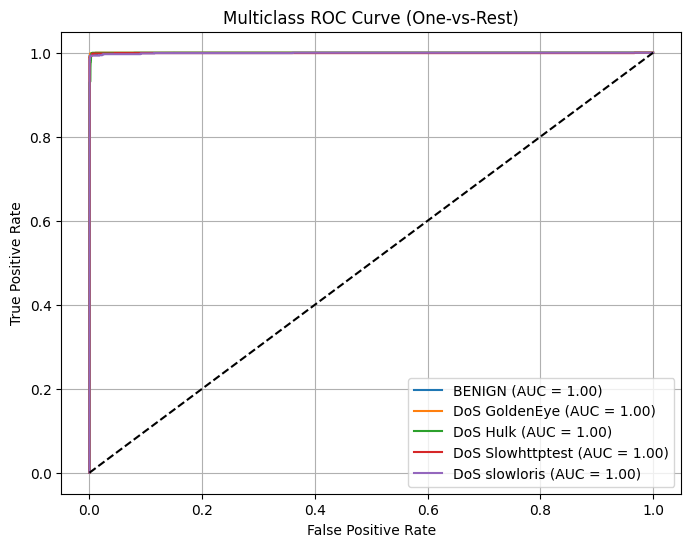

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Binarize labels for multiclass ROC
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# cnn_preds is already softmax output (shape: [n_samples, n_classes])
fpr = dict()
tpr = dict()
roc_auc = dict()

# 2. Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], cnn_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [6]:
import pandas as pd

# Convert label back to readable names
df['Class'] = le.inverse_transform(y_encoded)

# Select key features to analyze
selected_features = [
    'Packet Length Std',
    'Avg Bwd Segment Size',
    'Packet Length Variance',
    'Destination Port',
    'Idle Mean',
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets'
]

# Group by class and calculate mean
summary_table = df.groupby('Class')[selected_features].mean().round(2)
display(summary_table)

,Packet Length Std,Avg Bwd Segment Size,Packet Length Variance,Destination Port,Idle Mean,Flow Duration,Total Fwd Packets,Total Backward Packets
Class,,,,,,,,
BENIGN,135.97,161.25,88936.20,8812.44,3500511.92,10901371.85,10.49,11.93
DoS GoldenEye,1271.79,1256.71,2567285.50,80.00,18742768.02,23127222.22,5.90,3.71
DoS Hulk,1222.17,1286.72,2346291.37,80.00,56333922.58,57317129.17,5.29,4.22
DoS Slowhttptest,145.90,44.79,103891.58,80.00,29518278.97,57719891.73,5.74,0.96
DoS slowloris,50.15,7.26,6792.87,80.00,27347383.95,56554365.02,6.34,1.66
